In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import LearningRateScheduler
from tensorboard.plugins.hparams import api as hp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import datetime

%load_ext tensorboard

In [ ]:
# load dataset
#data = pd.read_json('/content/drive/MyDrive/Accountstory/data/TRAINING_dataset.json')
data = pd.read_json('/content/drive/MyDrive/Accountstory/data/TRAINING_dataset_20210930.json')
#data = pd.read_json('../../data/TRAINING_dataset.json')
data

In [ ]:
important_features = pd.read_csv('/content/drive/MyDrive/Accountstory/data/feat_importance.csv')
#important_features = pd.read_csv('../../data/feat_importance.csv')
important_features = list(important_features['gender'])

In [ ]:
#X = data.drop('stakeholder_category', axis=1) # all Features
X = data[important_features]
y = data['stakeholder_category'] # Target variable

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

* tune hyper params (2 layer architecture + dropouts)

In [ ]:
def run(batch, neurons_1, neurons_2, act, drop_1, drop_2, lr, epochs, verbose=0):
    tf.random.set_seed(1)
    model = keras.models.Sequential([
                                  keras.layers.Flatten(input_shape=[X_train.shape[1]]),
                                  keras.layers.BatchNormalization(),
                                  #keras.layers.LayerNormalization(axis=1),
                                  keras.layers.Dense(neurons_1, activation=act, kernel_regularizer='l1_l2'),
                                  #keras.layers.Dense(1000, activation="relu", 
                                                      #kernel_constraint=tf.keras.constraints.MaxNorm(max_value=1, axis=0)
                                                      #),
                                  keras.layers.BatchNormalization(),
                                  keras.layers.Dropout(drop_1),
                                  keras.layers.Dense(neurons_2, activation=act, kernel_regularizer='l1_l2'),
                                  keras.layers.Dropout(drop_2),
                                  #keras.layers.Dense(10, activation="relu", kernel_regularizer='l1_l2'),
                                  #keras.layers.Dense(10, activation="relu"),
                                  keras.layers.Dense(1, activation="sigmoid")
                                  ])

    model.compile(loss="binary_crossentropy",
                    optimizer="adam",
                    metrics=["Accuracy"],
                )

    lr_sched = LearningRateScheduler(lambda epoch: lr)

    history = model.fit(X_train, y_train, 
                      epochs=epochs, 
                      batch_size = batch,
                      validation_data=(X_test, y_test),
                      callbacks=[lr_sched],
                        verbose=verbose
                      )
  
    return max(history.history['val_Accuracy'])

In [ ]:
best = [0, 0, 0, 0, 0, 0, 0, 0]

batch = [16, 32]
neurons_1 = [16, 128, 512, 1024]
act = ['relu', 'selu']
drop_1 = [0, .1, .3, .5]
drop_2 = [0, .1, .3, .5]
lr = [1e-4, 3e-4]

for b in batch:
  for n1 in neurons_1:
    for n2 in [n1/4, n1/2]:
      for a in act:
        for d1 in drop_1:
          for d2 in drop_2:
            for l in lr:
              print('#' * 40)
              print('batch =', b)
              print('neurons_1 =', n1)
              print('neurons_2 =', n2)
              print('act =', a)
              print('dropout_1 =', d1)
              print('dropout_2 =', d2)
              print('lr =', l)
              print('#' * 40)
              
              acc = run(b, n1, n2, a, d1, d2, l, 50)
              if acc > best[0]:
                best = [acc, b, n1, n2, a, d1, d2, l]
              
              print('#' * 40)
              print('current:',round(acc,4))
              print('----')
              print('best:',round(best[0],4), best[1:])
              print('#' * 40)

In [ ]:
best

[0.7979797720909119, 16, 16, 8.0, 'selu', 0, 0, 0.0001]

* fine tune hyperparams

In [ ]:
tf.random.set_seed(1234)

model = keras.models.Sequential([
                                 keras.layers.Flatten(input_shape=[X_train.shape[1]]),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.LayerNormalization(axis=1),
                                 #keras.layers.Dense(3000, activation="relu"),
                                 keras.layers.Dense(100, activation="selu", kernel_regularizer='l2'), 
                                                    #kernel_constraint=tf.keras.constraints.MaxNorm(max_value=1, axis=0)
                                                    #),
                                 #keras.layers.Dropout(.10),
                                 #keras.layers.BatchNormalization(),
                                 keras.layers.Dense(50, activation="selu", kernel_regularizer='l2'),
                                 #keras.layers.Dropout(.02),
                                 #keras.layers.Dense(10, activation="relu", kernel_regularizer='l1_l2'),
                                 #keras.layers.Dense(10, activation="relu"),
                                 #keras.layers.BatchNormalization(),

                                 keras.layers.Dense(1, activation="sigmoid")
                                 ])

model.compile(loss="binary_crossentropy",
              optimizer='adam',#f.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.1, nesterov=False, name='adam'),
              metrics=["Accuracy"],
              )

lr_sched = LearningRateScheduler(lambda epoch: 1e-4)

history = model.fit(X_train, y_train, 
                    epochs=87, 
                    batch_size = 16,
                    validation_data=(X_test, y_test),
                    callbacks=lr_sched,
                    )

# plot results
pd.DataFrame(np.array([history.history['Accuracy'],history.history['val_Accuracy'],history.history['loss'],history.history['val_loss']]).T).plot()
plt.legend(['Acc', 'val_Acc','Loss','val_Loss'])
plt.ylim(0, 1)

* F1 score

In [ ]:
from sklearn.metrics import fbeta_score
fbeta_score(y_test, y_pred, beta=1)

0.7608695652173914

* make predictions with scalable threshold for output (sigmoid) layer of the NN

In [ ]:
y_pred = (model.predict(X_test) > 0.75).astype('int32')

* confusion matrix (for the different thresholds)

Text(33.0, 0.5, 'Actual')

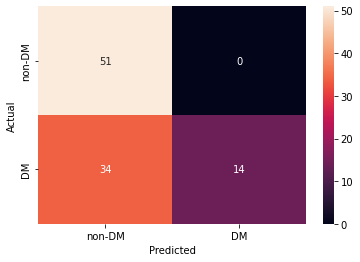

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
cm = confusion_matrix(y_test, y_pred) 
tn, fp, fn, tp = cm.ravel()

df_cm = pd.DataFrame(np.array([[tn, fp],[fn,tp]]), index = ['non-DM','DM'],
                  columns = ['non-DM','DM'])
plt.figure()


p=sn.heatmap(df_cm, annot=True)
p.set_xlabel('Predicted')
p.set_ylabel('Actual')